In [410]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import os
import re
import shutil

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import export_graphviz
import graphviz

%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')

# RANDOM_STATE = 25 
# 43: 0.04, -0.015
RANDOM_STATE_SPLIT = 3
RANDOM_STATE_REGR = 13

# TODO: try speed!!

In [411]:
n_samples =None
memory_experiment = None
remove_na = True
simple_lm_prior = True

second_visit = 1
gender = None
iqr_coefficient = None # if None then no standrat removal of outliers
# outcome = f"z_global_change.0.{second_visit}"
# outcome = f"z_change_snap_game_true_pos_rt_avrg.0.{second_visit}"
# outcome =f"z_change_log_pairs_matching_sum_incorrect.0.{second_visit}"


# outcome = f"z_change_num_memory_max_digits_remembered_correctly.0.{second_visit}"

# for snap game it is better to take quad baseline
# for pm it is better to keep log baseline as predictor
focus_experiment = "snap_game_true_pos_rt_avrg" 

outcome = f"{focus_experiment}.change.0.{second_visit}"
weight = -1

 
interactions_sg_change = [[f"{focus_experiment}.0", f"log_time_difference.0.{second_visit}"],[f"quadr_{focus_experiment}.0", f"log_time_difference.0.{second_visit}"]]
# interactions = interactions_sg_change
interactions = []

input_file = f"/projects/prime/ukbb/results_2024/all_cogn_0_{second_visit}_28_07/data_with_na.csv"
output_dir =f"/projects/prime/ukbb/results_2024/all_cogn_0_{second_visit}_28_07/regressor_{outcome}"

if gender is None:
  output_dir = f"{output_dir}/"
else:
  output_dir = f"{output_dir}_gender_{gender}/"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)



In [412]:
def my_stratification(df_, fld_name, quantiles, lim, global_strat):
   
    first = False
    df_ = df_.assign(**{"combined_labe_test": ""})
    if "combined_label" not in df_.columns: 
        df_ = df_.assign(**{"combined_label": ""})
        first = True
    if quantiles is None:
        if first:
            df_["combined_label"] = df_[fld_name].astype(int).astype(str)
            print(fld_name)
        else:
            df_["combined_label_test"] = df_["combined_label"]+"_"+df_[fld_name].astype(int).astype(str)
            values_combined_label_test = df_["combined_label_test"].drop_duplicates().tolist()
            
            if len(values_combined_label_test) > lim:
                df_ = df_.drop(columns=["combined_label_test"], axis=1)
                return df_
            
            enough = True
            
            for i in range(len(values_combined_label_test)):
                lab_val = values_combined_label_test[i]
                df_tmp = df_[df_["combined_label_test"].eq(lab_val)]
                if len(df_tmp) < 2:
                    # will merge this and next one some we will have more values in the extended bin
                    if i< len(values_combined_label_test) - 1:
                        df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i+1]
                    else:
                        # try merge with the previous
                        if i>0:
                            df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i-1]
                            df_tmp = df_[df_["combined_label_test"].eq(values_combined_label_test[i-1])]
                            if len(df_tmp) < 2:
                                enough = False
                                break
                            else:
                                values_combined_label_test[i] = values_combined_label_test[i-1]
                        else:
                            enough = False
                            break
                             
                        
                    
            if enough:
                df_["combined_label"] = df_["combined_label_test"]
                print(fld_name)
            
            df_ = df_.drop(columns=["combined_label_test"], axis=1)
                
    else: # quantiles
        df_ = df_.assign(**{"tmp": 0})
         
        if global_strat:
            qw =np.zeros(len(quantiles))
            for i in range(len(quantiles)):
                qw[i] = df_[fld_name].quantile(quantiles[i])
                
            df_.loc[df_[fld_name].le(qw[0]), "tmp"] = 1
            for i in range(1, len(quantiles)):
                df_.loc[df_[fld_name].gt(qw[i-1])& df_[fld_name].le(qw[i]), "tmp"] = i+1
            
        else: # local qunatile per per bin
            values_combined_label = df_["combined_label"].drop_duplicates().tolist()
            for lab_val in values_combined_label:
                df_tmp = df_[df_["combined_label"].eq(lab_val)]
                qw = np.zeros(len(quantiles))
                for i in range(len(quantiles)):
                    qw[i] = df_tmp[fld_name].quantile(quantiles[i])
                
                df_.loc[df_["combined_label"].eq(lab_val) & df_[fld_name].le(qw[0]), "tmp"] = 1
                for i in range(1, len(quantiles)):
                    df_.loc[df_["combined_label"].eq(lab_val) & df_[fld_name].gt(qw[i-1])& df_[fld_name].le(qw[i]), "tmp"] = i+1
        
        if first:
            df_["combined_label_test"] = df_["tmp"].astype(str)
        else:
            df_["combined_label_test"] = df_["combined_label"]+"_"+df_["tmp"].astype(str)
        df_ = df_.drop(columns=["tmp"], axis=1)
        values_combined_label_test = df_["combined_label_test"].drop_duplicates().tolist()
        
        if len(values_combined_label_test) > lim: # the number of classes exceeds the number of test points
            df_ = df_.drop(columns=["combined_label_test"], axis=1)
            return df_
        
        enough = True
        
        for i in range(len(values_combined_label_test)):
            lab_val = values_combined_label_test[i]
            df_tmp = df_[df_["combined_label_test"].eq(lab_val)]
            if len(df_tmp) < 2:
                # will merge this and next one some we will have more values in the extended bin
                if i< len(values_combined_label_test) - 1:
                    df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i+1]
                else:
                    # try merge with the previous
                    if i>0:
                        df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i-1]
                        df_tmp = df_[df_["combined_label_test"].eq(values_combined_label_test[i-1])]
                        if len(df_tmp) < 2:
                            enough = False
                            break
                        else:
                            values_combined_label_test[i] = values_combined_label_test[i-1]
                    else:
                        enough = False
                        break
                            
            
        if enough:
            print(fld_name)
            df_["combined_label"] = df_["combined_label_test"]
       
        df_ = df_.drop(columns=["combined_label_test"], axis=1)
    return df_
            
        

In [413]:
# function for removing outliers via iqr approach
def remove_outliers_iqr(df_, iqr_cf,  outliers):
    print(f"# data points before removing outliers: {len(df_)}")
    if iqr_cf is not None:
        
        lower_bound = {}
        upper_bound = {}
        
        for feat  in outliers:
            print(f"{feat}")
            
            Q1 = df_[feat].quantile(0.25)
            Q3 = df_[feat].quantile(0.75)
            
            IQR = Q3-Q1
            lower_bound[feat] = Q1 - iqr_cf * IQR
            upper_bound[feat] = Q3 + iqr_cf * IQR
            
            
            
        for feat in lower_bound:
            df_= df_[(df_[feat] >= lower_bound[feat]) & (df_[feat] <= upper_bound[feat])]
            
        print(f"# data points after removing outliers: {len(df_)}")
    return(df_)

In [414]:

simple_predictors = [f"log_time_difference.0.{second_visit}", "age_years.0", "gender.0", "education_level.0",
                     f"quadr_{focus_experiment}.0"]



In [415]:
risk_factors = ["Syst_bp.0", "Diast_bp.0", "ldl_conv.0", "hdl_conv.0", "Triglycerides_conv.0", "HbA1c_conv.0",  "Albumin.0", 
  "Leukocyte_count.0", "C_reactive_protein.0"]
metrics =["MET_score.0", "bmi_kg_m2.0", "waist_cm.0"]
diet = ["oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0",
    "cereals_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "milk_gpday_bradbury.0", "tea_gpday_bradbury.0"]
diagnoses = [ "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0"]
alc_drinks = [ "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0"]
others_cat =["marital_status.0", "pp_smoke_catgeory.0"]
medications = ["aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", 
   "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]

In [416]:
predictors = simple_predictors + metrics +diet + alc_drinks +risk_factors +  others_cat +diagnoses + medications

In [417]:
# 900, 5  log
'''predictors = ["gender.0", f"log_time_difference.0.{second_visit}", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0", 
  "age_years.0", "education_level.0", "marital_status.0", "pp_smoke_catgeory.0", "log_MET_score.0", "log_waist_cm.0",  "log_bmi_kg_m2.0", 
  "Syst_bp.0", "Diast_bp.0", "log_ldl_conv.0", "log_hdl_conv.0", "log_Triglycerides_conv.0", "log_HbA1c_conv.0",  "log_Pl_glucose_conv.0",   "log_Albumin.0", 
  "log_Leukocyte_count.0", "log_C_reactive_protein.0",
   "log_oily_fish_gpday_bradbury.0", "log_white_fish_gpday_bradbury.0", 
   "log_red_meat_bradbury_gpd.0", "log_poultry_gpday_bradbury.0",
   "log_processed_meat_gpday_bradbury.0", "log_veg_gpday_bradbury.0",
   "log_fruit_gpday_bradbury.0",
    "log_cereals_gpday_bradbury.0", "log_bread_gpday_bradbury.0", "log_cheese_gpday_bradbury.0",
    "log_milk_gpday_bradbury.0", "log_tea_gpday_bradbury.0",
    "log_red_wine_gpd.0", "log_white_wine_gpd.0", "log_fortified_gpd.0", "log_beer_cider_gpd.0", "log_spirits_gpd.0",
   "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]'''

'predictors = ["gender.0", f"log_time_difference.0.{second_visit}", \n              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0", \n  "age_years.0", "education_level.0", "marital_status.0", "pp_smoke_catgeory.0", "log_MET_score.0", "log_waist_cm.0",  "log_bmi_kg_m2.0", \n  "Syst_bp.0", "Diast_bp.0", "log_ldl_conv.0", "log_hdl_conv.0", "log_Triglycerides_conv.0", "log_HbA1c_conv.0",  "log_Pl_glucose_conv.0",   "log_Albumin.0", \n  "log_Leukocyte_count.0", "log_C_reactive_protein.0",\n   "log_oily_fish_gpday_bradbury.0", "log_white_fish_gpday_bradbury.0", \n   "log_red_meat_bradbury_gpd.0", "log_poultry_gpday_bradbury.0",\n   "log_processed_meat_gpday_bradbury.0", "log_veg_gpday_bradbury.0",\n   "log_fruit_gpday_bradbury.0",\n    "log_cereals_gpday_bradbury.0", "log_bread_gpday_bradbury.0", "log_cheese_gpday_bradbury.0",\n    "log_milk_gpday_bradbury.0", "log_tea_gpday_bradbury.0",\n    "log_red_wine_gpd.0", "log_white_wine_gpd.0", "log_fortified_gpd.0", "log_beer_

In [418]:
cat_predictors = ["gender.0", "education_level.0", "marital_status.0", "pp_smoke_catgeory.0", "Diabetes_2.0",  
                  "Dyslipidemia.0", "Depression.0", "Hypertension.0", 
    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", 
   "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0",  "learning_effect_prior.2"]

In [419]:
df = pd.read_table(input_file, nrows=n_samples,sep =",")
df = df[predictors+[outcome]]


In [420]:
print(f"data set {len(df)} rows")
if remove_na:
    df = df.dropna(axis="rows")
    print(f"cleaned check up db has {len(df)} rows")


data set 502204 rows
cleaned check up db has 4225 rows


In [421]:
 
if gender is not None:
   df = df[df["gender.0"].eq(gender) ]
   predictors.remove("gender.0")
   df = df.drop(columns=["gender.0"], axis=1)
       
df = remove_outliers_iqr(df, iqr_coefficient, df.columns) 

# data points before removing outliers: 4225


In [422]:
for clmn in df.columns:
    if "num_mem" in clmn:
        print(clmn)

In [423]:
assign_ ={}   
    
for interaction in interactions:
    clmn = f"{interaction[0]}x{interaction[1]}"
    assign_[clmn] = df[interaction[0]] * df[interaction[1]] 
    
df = df.assign(**assign_)

In [424]:
features = [x for x in df.columns if x not in [outcome]]
# features = [x for x in df.columns if x not in outcome]

In [425]:
print(features)
df = df.reset_index()

['log_time_difference.0.1', 'age_years.0', 'gender.0', 'education_level.0', 'snap_game_true_pos_rt_avrg.0', 'MET_score.0', 'bmi_kg_m2.0', 'waist_cm.0', 'oily_fish_gpday_bradbury.0', 'white_fish_gpday_bradbury.0', 'red_meat_bradbury_gpd.0', 'poultry_gpday_bradbury.0', 'processed_meat_gpday_bradbury.0', 'veg_gpday_bradbury.0', 'fruit_gpday_bradbury.0', 'cereals_gpday_bradbury.0', 'bread_gpday_bradbury.0', 'cheese_gpday_bradbury.0', 'milk_gpday_bradbury.0', 'tea_gpday_bradbury.0', 'red_wine_gpd.0', 'white_wine_gpd.0', 'fortified_gpd.0', 'beer_cider_gpd.0', 'spirits_gpd.0', 'Syst_bp.0', 'Diast_bp.0', 'ldl_conv.0', 'hdl_conv.0', 'Triglycerides_conv.0', 'HbA1c_conv.0', 'Albumin.0', 'Leukocyte_count.0', 'C_reactive_protein.0', 'marital_status.0', 'pp_smoke_catgeory.0', 'Diabetes_2.0', 'Dyslipidemia.0', 'Depression.0', 'Hypertension.0', 'aspirin.0', 'anxiety_tr.0', 'pain_tr.0', 'TAZD_Thiazide.0', 'loop_diuretics.0', 'potassium_diuretics.0', 'beta_blockers.0', 'calcium_antagonists.0', 'ARA_II_A

In [426]:
# X_train, X_val, y_train, y_val = train_test_split(df[features], df[outcome], train_size = 0.7, random_state = RANDOM_STATE_SPLIT)
'''
l = len('quan_')
df['strata_key'] = df["gender.0"].astype(int).astype(str) 
for cat_feat in cat_predictors:
    if cat_feat == "gender.0":
        continue
    if "quan_" in cat_feat:
        pure_feat = cat_feat[l:]
        df[cat_feat] = pd.qcut(df[pure_feat], q=2, labels=[1,2])
    
    tmp  = df['strata_key'] + "_" + df[cat_feat].astype(int).astype(str)
    # check that eacj class has 2 elements and if yes, then add to stratification
    df['strata_key'] = tmp

stratify_key = df['strata_key']
print(stratify_key)
'''

'\nl = len(\'quan_\')\ndf[\'strata_key\'] = df["gender.0"].astype(int).astype(str) \nfor cat_feat in cat_predictors:\n    if cat_feat == "gender.0":\n        continue\n    if "quan_" in cat_feat:\n        pure_feat = cat_feat[l:]\n        df[cat_feat] = pd.qcut(df[pure_feat], q=2, labels=[1,2])\n    \n    tmp  = df[\'strata_key\'] + "_" + df[cat_feat].astype(int).astype(str)\n    # check that eacj class has 2 elements and if yes, then add to stratification\n    df[\'strata_key\'] = tmp\n\nstratify_key = df[\'strata_key\']\nprint(stratify_key)\n'

In [427]:
vars = features
percentage_test = 0.25
lim_ = percentage_test * len(df)
global_stratification = True

quantiles = [0.2, 0.4, 0.6, 0.8, 1]
for clmn in vars:
   
    if clmn in cat_predictors:
        df = my_stratification(df, clmn, None, lim_, global_stratification)
    else:
        df = my_stratification(df, clmn, quantiles, lim_, global_stratification)

df.to_csv(f"{output_dir}/labelled_strata_global_{global_stratification}.csv")

log_time_difference.0.1
age_years.0
gender.0
education_level.0
snap_game_true_pos_rt_avrg.0
milk_gpday_bradbury.0
fortified_gpd.0
marital_status.0
Diabetes_2.0
anxiety_tr.0
loop_diuretics.0
potassium_diuretics.0
calcium_antagonists.0
ARA_II_Antagonists_of_angiotensin_II_receptors.0
Other_Hypotensive.0
hypochol_others.0
insulin.0
sulfonylurea.0
thiazolidinediones.0
non_sulfonylurea_insulin_secretagogues.0
metformin_category.0


In [428]:
values_combined_label = df["combined_label"].drop_duplicates().tolist()
print(values_combined_label)

['3_4_1_3_3_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '5_1_1_1_4_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_1_3_5_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_3_0_1_2_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_5_0_3_2_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_4_1_1_5_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_2_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_2_0_3_1_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '3_4_1_2_5_1_5_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '5_1_1_1_2_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_1_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_3_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_3_0_2_4_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_1_0_1_2_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_5_0_2_4_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_4_1_3_2_1_5_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_1_0_1_1_3_5_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_4_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_1_3_5_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_5_0_3_4_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_5_1_3_1_1_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '1_3_0_3_5_3_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0', '2_1_0_3_

In [429]:

features_stratify = features + ["combined_label"]
X = df[features_stratify]
y = df[outcome]


X_train_list = []
X_valid_list = []
y_train_list = []
y_valid_list = []

sss = StratifiedShuffleSplit(n_splits=4, test_size=percentage_test,random_state=RANDOM_STATE_SPLIT )
for fold, (train_index, valid_index) in enumerate(sss.split(X, X["combined_label"])):
    print(f"Fold {fold+1}")
    X_train, X_valid = X.loc[train_index], X.loc[valid_index]
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    y_train, y_valid = y.loc[train_index], y.loc[valid_index]
    y_train_list.append(y_train)
    y_valid_list.append(y_valid)
    

Fold 1
Fold 2
Fold 3
Fold 4


In [430]:
df= df.drop(columns=["combined_label"], axis=1)

In [431]:
n_fold = 1

X_train = X_train_list[n_fold][features]
y_train = y_train_list[n_fold] * weight

X_val = X_valid_list[n_fold][features]
y_val = y_valid_list[n_fold] * weight


In [432]:
scaler_simple = StandardScaler()

X_train_simple = X_train[simple_predictors]
X_val_simple = X_val[simple_predictors]

X_train_simple_scaled = scaler_simple.fit_transform(X_train_simple)
X_val_simple_scaled = scaler_simple.transform(X_val_simple)

model_simple = LinearRegression()
model_simple.fit(X_train_simple_scaled, y_train)
       
y_simple_pred_train = model_simple.predict(X_train_simple_scaled)   

mae_simple_tr = mean_absolute_error(y_train, y_simple_pred_train)
mse_simple_tr = mean_squared_error(y_train, y_simple_pred_train)
rmse_simple_tr = mean_squared_error(y_train, y_simple_pred_train, squared=False)  # RMSE is the square root of MSE
r2_simple_tr = r2_score(y_train, y_simple_pred_train)

validation_summary = f"Train mean_absolute_error  { mae_simple_tr}\n" 
validation_summary += f"Train simple model root mean_squared_error  {rmse_simple_tr}\n"
validation_summary += f"Train simple model R-squared (the coefficient of determination) {r2_simple_tr}\n"


 
y_simple_pred_val = model_simple.predict(X_val_simple_scaled)

mae_simple = mean_absolute_error(y_val, y_simple_pred_val)
mse_simple = mean_squared_error(y_val, y_simple_pred_val)
rmse_simple = mean_squared_error(y_val, y_simple_pred_val, squared=False)  # RMSE is the square root of MSE
r2_simple = r2_score(y_val, y_simple_pred_val)
   

validation_summary += f"vaidation simple model mean_absolute_error  { mae_simple}\n"
validation_summary += f"vaidation simple model root mean_squared_error  {rmse_simple}\n"
validation_summary += f"vaidation simple model R-squared (the coefficient of determination) {r2_simple}\n"
    
print(validation_summary)

Train mean_absolute_error  62.404254581500915
Train simple model root mean_squared_error  86.2300349721737
Train simple model R-squared (the coefficient of determination) 0.19692946897813646
vaidation simple model mean_absolute_error  65.69543333832651
vaidation simple model root mean_squared_error  92.33911301070323
vaidation simple model R-squared (the coefficient of determination) 0.17846301251172791



/home/olha/.pyenv/versions/3.11.1/envs/copula/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/olha/.pyenv/versions/3.11.1/envs/copula/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [433]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
min_ = df[outcome].min()
max_ = df[outcome].max()
median_ = df[outcome].median()
mean_ = df[outcome].mean()
print(f"tr min {outcome}: {min_}")
print(f"tr max {outcome}: {max_}")
print(f"tr median {outcome}: {median_}")
print(f"tr mean {outcome}: {mean_}")

train samples: 3168
validation samples: 1057
tr min snap_game_true_pos_rt_avrg.change.0.1: -735.0
tr max snap_game_true_pos_rt_avrg.change.0.1: 851.0
tr median snap_game_true_pos_rt_avrg.change.0.1: 7.0
tr mean snap_game_true_pos_rt_avrg.change.0.1: 9.690887573964497


In [434]:
if simple_lm_prior:
    y_train =  y_train - y_simple_pred_train
    y_valid =  y_valid - y_simple_pred_val

In [458]:
# factors = risk_factors + metrics +diet + alc_drinks + others_cat +diagnoses + medications
factors = risk_factors + metrics +diet + alc_drinks + others_cat +diagnoses + medications
X_train_rest = X_train[factors ]
X_val_rest = X_val[factors ]

In [459]:
scaler_lm = StandardScaler()
X_train_scaled = scaler_lm.fit_transform(X_train_rest)
X_val_scaled = scaler_lm.transform(X_val_rest)
    
    # main model    
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
    
y_pred_train = lin_model.predict(X_train_scaled)
y_pred_val = lin_model.predict(X_val_scaled)
   
mae = mean_absolute_error(y_valid, y_pred_val)
mse = mean_squared_error(y_valid, y_pred_val)
rmse = mean_squared_error(y_valid, y_pred_val, squared=False)  # RMSE is the square root of MSE
r2 = r2_score(y_valid, y_pred_val)
    
validation_summary = f"vaidation mean_absolute_error  { mae}\n"
validation_summary += f"vaidation root mean_squared_error  {rmse}\n"
validation_summary += f"vaidation R-squared (the coefficient of determination) {r2}\n"

# Extract parameters
intercept = lin_model.intercept_
coefficients = lin_model.coef_

# Calculate metrics
mse_tr= mean_squared_error(y_train, y_pred_train)
r2_tr = r2_score(y_train, y_pred_train)

# Print summary
print("Linear Regression Summary:")
print("==========================")
print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")
print(f"Mean Squared Error: {mse_tr}")
print(f"R-squared: {r2_tr}")

Linear Regression Summary:
Intercept: -5.422532334986204e-15
Coefficients: [ 2.50632416e+00 -4.71164869e-01 -9.44859040e-01 -1.81749935e+00
 -2.37811460e+00 -2.23726139e+00  1.37016313e+00 -4.79058570e-01
  4.18330869e-01 -1.10055617e+00  2.66004269e+00 -2.55449280e+00
 -1.45424877e+00  1.70302296e+00  9.12827629e-01 -1.55325117e+00
  1.76560784e+00 -8.32038429e-01  8.82736832e-01 -5.51948812e-01
 -1.83663397e+00 -1.26558166e+00 -6.72443745e-01  6.24327402e-01
  4.90407515e-01 -1.28558070e+00 -1.20135167e+00 -1.48220968e+00
  3.70586891e+00 -1.14190482e+00  1.44287833e+00 -2.74358576e+00
 -1.91568622e+00  1.13141808e+00 -2.26270691e+00 -2.70763776e-01
 -8.53112899e-01 -1.82270358e+00 -3.32811883e+00 -3.05432078e-01
  1.40819262e+00 -3.33137745e-01  2.22044605e-16  4.32904971e-01
 -9.90544837e-01 -1.09297755e+00  3.90080885e+00 -2.66943785e+00
  9.24953161e-01 -1.50884274e+00 -2.89713175e+00  2.20159376e+00
  1.14694834e+00  1.58677875e+00]
Mean Squared Error: 7305.883794976511
R-square

/home/olha/.pyenv/versions/3.11.1/envs/copula/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [460]:
print(validation_summary)

vaidation mean_absolute_error  84.16139024540176
vaidation root mean_squared_error  112.17948881593166
vaidation R-squared (the coefficient of determination) -0.033918394723270184



In [438]:
def r1(y_pred, y_true, median_):
    abs_error_pred = (np.abs(y_true - y_pred)).sum()
    abs_error = (np.abs(y_true - median_)).sum()
    r1 = 1 -abs_error_pred/abs_error
    return r1

y_tr = pd.Series([1,2,3])
m_ = y_tr.median()
print(f"test median {m_}")
y_pr = pd.Series([m_, m_, m_]) # 
test = r1(y_pr, y_tr, m_)
print(f"test r1 function: {test}")

test median 2.0
test r1 function: 0.0


In [461]:
m_smaples_split = 50
m_samples_leaf = 25
m_depth = 6


In [462]:
specific_name = f"{m_smaples_split}_{m_samples_leaf}_{m_depth}_{RANDOM_STATE_REGR}_fold_{n_fold}_glob_strata_{global_stratification}"

regressor = DecisionTreeRegressor(min_samples_leaf = m_samples_leaf,
                                  min_samples_split =  m_smaples_split,
                                  max_depth = m_depth,
                                  random_state = RANDOM_STATE_REGR)

'''
if linear_regress_before_tree: # we need to standartise because we have standartised the simple ones
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
'''

regression_tree_model = regressor.fit(X_train,y_train)

print(f"MAE train:\n\t: {mean_absolute_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"RMSE train:\n\t: {np.sqrt(mean_squared_error(regression_tree_model.predict(X_train),y_train)):.4f}")
print(f"RMSE validation:\n\t: {np.sqrt(mean_squared_error(regression_tree_model.predict(X_val),y_val)):.4f}")
print(f"R1 train:\n\t: {r1(regression_tree_model.predict(X_train),y_train,median_):.4f}")
print(f"R1 validation:\n\t: {r1(regression_tree_model.predict(X_val),y_val, median_):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")


MAE train:
	: 60.7426
MAE validation:
	: 74.5097
RMSE train:
	: 83.0629
RMSE validation:
	: 104.8068
R1 train:
	: 0.0167
R1 validation:
	: -0.0166
R2 train:
	: -11.8678
R2 validation:
	: -20.5782


In [463]:
specific_name_val = f"{m_smaples_split}_{m_samples_leaf}_{m_depth}_{RANDOM_STATE_REGR}_fold_{n_fold}__glob_strata_{global_stratification}_valid"

regressor_val= DecisionTreeRegressor(min_samples_leaf = m_samples_leaf,
                                  min_samples_split =  m_smaples_split,
                                  max_depth = m_depth,
                                  random_state = RANDOM_STATE_REGR)
regression_tree_model_val = regressor_val.fit(X_val,y_val)

print(f"MAE VAL train:\n\t: {mean_absolute_error(regression_tree_model_val.predict(X_train),y_train):.4f}")
print(f"MAE VAL validation:\n\t: {mean_absolute_error(regression_tree_model_val.predict(X_val),y_val):.4f}")
print(f"RMSE VAL train:\n\t: {np.sqrt(mean_squared_error(regression_tree_model_val.predict(X_train),y_train)):.4f}")
print(f"RMSE VAL validation:\n\t: {np.sqrt(mean_squared_error(regression_tree_model_val.predict(X_val),y_val)):.4f}")
print(f"R1 VAL train:\n\t: {r1(regression_tree_model_val.predict(X_train),y_train,median_):.4f}")
print(f"R1 VAL validation:\n\t: {r1(regression_tree_model_val.predict(X_val),y_val, median_):.4f}")
print(f"R2 VAL train:\n\t: {r2_score(regression_tree_model_val.predict(X_train),y_train):.4f}")
print(f"R2 VAL validation:\n\t: {r2_score(regression_tree_model_val.predict(X_val),y_val):.4f}")

MAE VAL train:
	: 75.6179
MAE VAL validation:
	: 62.0502
RMSE VAL train:
	: 101.3223
RMSE VAL validation:
	: 87.2560
R1 VAL train:
	: -0.2240
R1 VAL validation:
	: 0.1534
R2 VAL train:
	: -2.7693
R2 VAL validation:
	: -1.7535


In [464]:
def show_importances(tree_model,name):
    

    # Retrieve the feature importances
    importances = tree_model.feature_importances_

    # Print the feature importances
    important_features = []
    important_importances = []
    df_importances = pd.DataFrame()

    for feature_name, importance in zip(features, importances):
        if importance > 0:
            important_features.append(feature_name)
            important_importances.append(importance)
            new_row = {'feature': feature_name, 'importance': importance}
            new_row_df = pd.DataFrame([new_row])
            df_importances = pd.concat([df_importances, new_row_df], ignore_index=True)
            
    print(df_importances)       
    df_importances.to_csv(f"{output_dir}/feature_importance_{m_smaples_split}_{m_samples_leaf}_{specific_name}.csv", sep =",")
    # Visualize the feature importances
    plt.figure(figsize=(10, 10))
    plt.barh(important_features, important_importances, align='center')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importances in DecisionTreeRegressor {name}")
    file_path = os.path.join(output_dir, 'feature_importances.png')
    plt.savefig(file_path)
    plt.show()


                        feature  importance
0       log_time_difference.0.1    0.110581
1                   age_years.0    0.107126
2  snap_game_true_pos_rt_avrg.0    0.221161
3                 spirits_gpd.0    0.072772
4                     Syst_bp.0    0.039464
5                    ldl_conv.0    0.046194
6                    hdl_conv.0    0.079274
7                  HbA1c_conv.0    0.212928
8             Leukocyte_count.0    0.043830
9          C_reactive_protein.0    0.066671


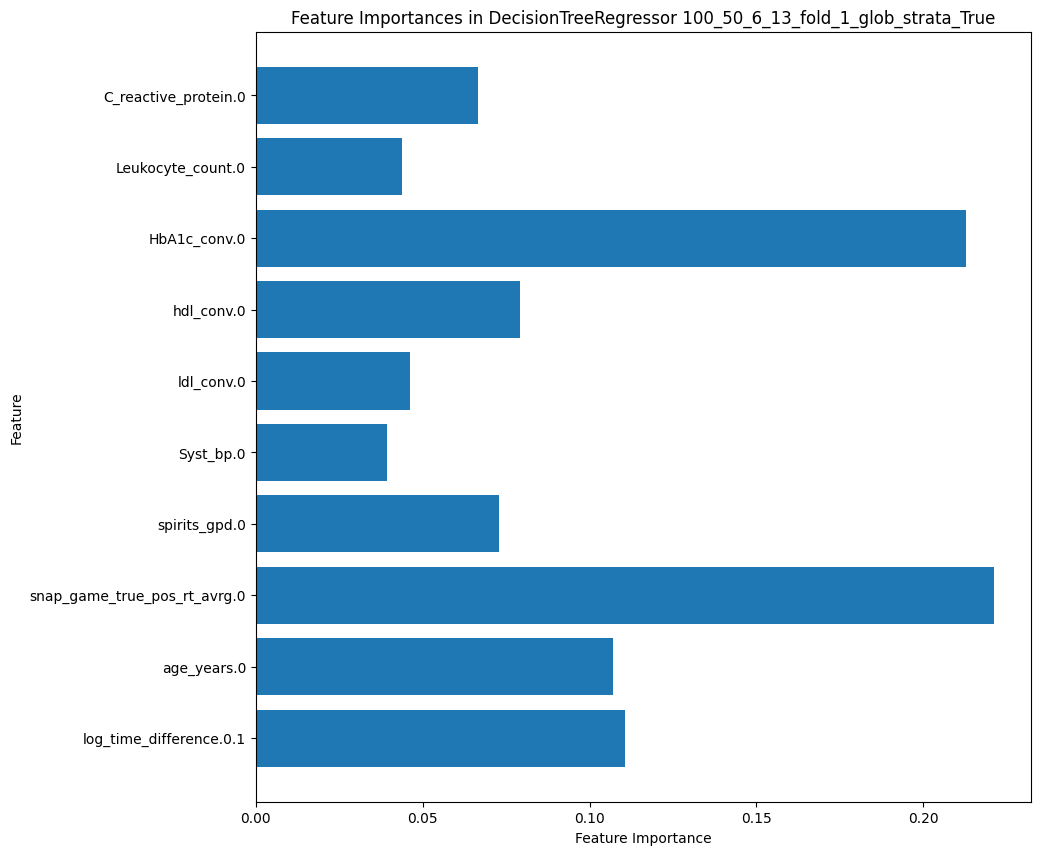

In [443]:
show_importances(regression_tree_model, specific_name)

                        feature  importance
0                   age_years.0    0.053593
1  snap_game_true_pos_rt_avrg.0    0.774551
2                   bmi_kg_m2.0    0.022947
3                     Syst_bp.0    0.024455
4                    Diast_bp.0    0.111440
5           vitamins_minerals.0    0.013014


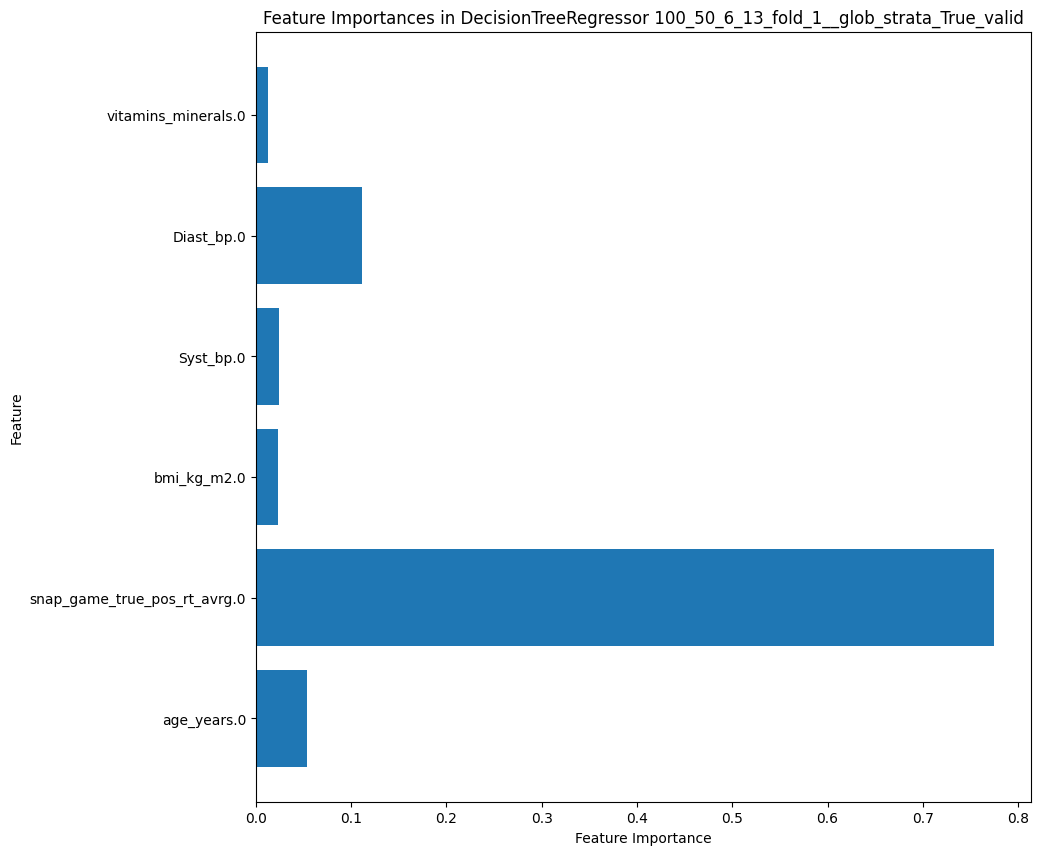

In [444]:
show_importances(regression_tree_model_val, specific_name_val)

In [445]:
def show_tree(regrsr, ft, name):
# adjusting colors
    values = regrsr.tree_.value.flatten()
    # Normalize the values for coloring
    norm = plt.Normalize(values.min(), values.max())
    # Create a custom color map (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellowRed", ["red", "yellow", "green"])

    # Generate colors for each node based on the normalized values and the custom color map
    colors = cmap(norm(values))

    dot_data_1 = export_graphviz(regrsr,  out_file=None, filled=True, rounded=True, special_characters=True,
                            feature_names=ft,
                            proportion=True)


    # Split the DOT data into lines
    dot_lines = dot_data_1.splitlines()
    hex_color_pattern = r'fillcolor="#[0-9a-fA-F]{6}"'

    # Modify the DOT file lines to include custom colors
    new_dot_lines = []
    for line in dot_lines:
        if 'fillcolor' in line:
            parts = line.split()
            if parts[0].isdigit():
                node_id = int(parts[0])
                # Get corresponding color
                color = mcolors.to_hex(colors[node_id])
                # Modify the line to include the color
                line = re.sub(hex_color_pattern, f'fillcolor="{color}"', line)
        new_dot_lines.append(line)

    # Combine the modified lines back into a single string
    new_dot_data = "\n".join(new_dot_lines)

    # Render the DOT file with Graphviz
    graph = graphviz.Source(new_dot_data)
    graph.render(f"tree_{name}_{outcome}", format='png')
    graph.render(f"{output_dir}/tree_{name}_{outcome}", format='png')
    graph.view()

In [446]:
show_tree(regressor, features, specific_name)

In [447]:
show_tree(regressor_val, features, specific_name_val)

Error: no "view" mailcap rules found for type "application/pdf"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.
Error: no "view" mailcap rules found for type "application/pdf"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.
